In [1]:
%%capture
!pip install scprep
!pip install anndata
!pip install scanpy

In [2]:
import numpy as np
import pandas as pd
import anndata
import scprep
import scanpy as sc
import sklearn
from sklearn.model_selection import train_test_split
import tempfile
import os
from os import path
import sys
import scipy
from scipy import sparse

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import load_raw
import normalize_tools as nm
import metrics

# **try out with scicar cell lines dataset**

**1. URLs for raw data**

In [3]:
rna_data, atac_data, rna_cells, atac_cells, rna_genes, atac_genes = load_raw.load_raw_cell_lines()

In [4]:
scicar_data, joint_index, keep_cells_idx = load_raw.merge_data(rna_data, atac_data, rna_cells, atac_cells, rna_genes, atac_genes)
#rna_df, atac_df = ann2df(scica|r_data)|

In [5]:
def clip(adata, prop_clip=0.5):
    assert isinstance(prop_clip, float) and 0.0 < prop_clip < 50.0
    clip_low, clip_high = np.percentile(adata.X.flatten(), [prop_clip, 100 - prop_clip])
    adata.X = np.clip(adata.X, clip_low, clip_high)

In [6]:
ATAC_KWARGS = {
    "binarize": False,
    "filter_gene_min_counts": 5, 
    "filter_gene_min_cells": 5,
    "filter_gene_max_cells": 0.1,
}

RNA_KWARGS = {
    "size_factor": True, 
    "log_trans": True, 
    "normalize": True, 
    "proportion": None,
    "prop_clip": 0.5,
}

In [7]:
def preprocess(
    adata,
    binarize=True,
    filter_gene_min_counts=5, 
    filter_gene_min_cells=5,
    filter_gene_max_cells=0.1,
    size_factor=True, 
    log_trans=True, 
    normalize=True, 
    proportion=None,
    prop_clip=0.5,
):
    #preprocess for RNA modality 
    #(log tranform normalize and scale to zero mena unit variance)
    nm.normalize_count_table(adata, proportion=proportion)
    clip(adata, prop_clip=prop_clip)
    
    #preprocess for ATAC modality (binarize and filter)
    if binarize:
        nm.binarize(adata, obsm="mode2", obs="mode2_obs", var="mode2_var")
    nm.filter_adata(
        adata, 
        filter_gene_min_counts=5, 
        filter_gene_min_cells=5,
        filter_gene_max_cells=0.1,
        obsm="mode2",
        obs="mode2_obs",
        var="mode2_var",
    )
    
    if not isinstance(adata.X, scipy.sparse.csr_matrix):
        adata.X = scipy.sparse.csr_matrix(adata.X)
        
    #figure out the obs and var info for adata
    adata.uns["mode2_obs"] = np.array(adata.uns["mode2_obs"][0])
    adata.uns["mode2_var"] = np.array(adata.uns["mode2_var"][0])
    adata.uns = {"mode2_obs": adata.uns["mode2_obs"], "mode2_var": adata.uns["mode2_var"]}
    
    dim_mode1 = adata.X.shape[1]
    dim_mode2 = adata.obsm["mode2"].shape[1]
    return adata, dim_mode1, dim_mode2

In [8]:
train_data_raw, test_data_raw, indices_train, mask_test= load_raw.train_test_split(scicar_data)
scicar_data_filtered, dim_rna, dim_atac = preprocess(scicar_data, **ATAC_KWARGS, **RNA_KWARGS)
train_data_filtered, test_data_filtered = load_raw.split_with_mask(scicar_data_filtered, indices_train, mask_test)

In [9]:
#set up all hyper-parameters
hyper = {
    "nEpochs":100,
    "dim_rna":dim_rna,
    "dim_atac":dim_atac,
    "n_latent":32,
    "layer_sizes":[64],
    "add_hinge":True,
    "lamb_hinge":50,
    "lamb_match":1,
    "lamb_nn":1.5,
    "train_batch":256,
    "test_batch": 512,
    "lr": 1e-3,
    "clip_grad": 1,
    "checkpoint_path": './checkpoint/babel_no_hinge.pt',
}

# **define pytorch datasets for RNA and ATAC**

In [10]:
class Merge_Dataset(Dataset):
    def __init__(self, adata_raw, adata_filtered):
        self.rna_data_filtered, self.atac_data_filtered = self._load_merge_data(adata_filtered)
        self.rna_data_raw = self._load_raw_ref_data(adata_raw)
        
    def __len__(self):
        #assert(len(self.rna_data) == len(self.atac_data))
        return len(self.atac_data_filtered)
  
    def __getitem__(self, idx):
        rna_filtered = self.rna_data_filtered.values[idx]
        atac_filtered = self.atac_data_filtered.values[idx]
        rna_raw = self.rna_data_raw.values[idx]
        #return a tensor that for a single observation
        return [
            torch.from_numpy(rna_filtered).float(), 
            torch.from_numpy(atac_filtered).float(),
            torch.from_numpy(rna_raw).float(),
        ]
  
    def _load_merge_data(self, adata):
        rna_df = pd.DataFrame(
            data = adata.X.toarray(), 
            index = np.array(adata.obs.index), 
            columns = np.array(adata.var.index),
        )
        atac_df = pd.DataFrame(
            data = adata.obsm["mode2"].toarray(),
            index = np.array(adata.uns["mode2_obs"]),
            columns = np.array(adata.uns["mode2_var"]),
        )
        return rna_df, atac_df
    
    def _load_raw_ref_data(self, adata_raw):
        rna_df = pd.DataFrame(
            data = adata_raw.X.toarray(), 
            index = np.array(adata_raw.obs.index), 
            columns = np.array(adata_raw.var.index),
        )
        return rna_df

# **define basic models (BABEL) for learning latent space**

In [11]:
class Exp(nn.Module):
    
    def __init__(self, min_val=1e-5, max_val=1e6):
        super(Exp, self).__init__()
        self.min_val = min_val
        self.max_val = max_val
    
    def forward(self, x):
        return torch.clamp(
            torch.exp(x),
            min=self.min_val,
            max=self.max_val,
        )
    
class ClippedSoftplus(nn.Module):
    
    def __init__(self, beta=1, threshold=20, min_val=1e-4, max_val=1e3):
        super(ClippedSoftplus, self).__init__()
        self.beta = beta
        self.threshold = threshold
        self.min_val = min_val
        self.max_val = max_val
    
    def forward(self, x):
        return torch.clamp(
            F.softplus(x, self.beta, self.threshold),
            min=self.min_val,
            max=self.max_val,
        )

In [12]:
class Encoder(nn.Module):
    def __init__(self, n_input, n_latent, layer_sizes):
        super(Encoder, self).__init__()
        self.n_input = n_input
        self.n_latent = n_latent
        self.layer_sizes = [n_input] + layer_sizes + [n_latent]
        self.encoder_layers = []
        
        for idx in range(len(self.layer_sizes) - 1):
            fc1 = nn.Linear(self.layer_sizes[idx], self.layer_sizes[idx + 1])
            nn.init.xavier_uniform_(fc1.weight)
            self.encoder_layers.append(fc1)
            bn1 = nn.BatchNorm1d(self.layer_sizes[idx + 1])
            self.encoder_layers.append(bn1)
            act1 = nn.PReLU()
            self.encoder_layers.append(act1)
            
        self.encoder = nn.Sequential(*self.encoder_layers)
        
    def forward(self, x):
        return(self.encoder(x))

In [13]:
class Decoder(nn.Module):
    def __init__(self, n_output, n_latent, layer_sizes, final_activation=None):
        super(Decoder, self).__init__()
        self.n_output = n_output
        self.n_latent = n_latent
        self.layer_sizes = [n_output] + layer_sizes + [n_latent]
        self.decoder1_layers = []
        for idx in range(len(self.layer_sizes) - 1, 1,  -1):
            fc1 = nn.Linear(self.layer_sizes[idx], self.layer_sizes[idx - 1])
            nn.init.xavier_uniform_(fc1.weight)
            self.decoder1_layers.append(fc1)
            bn1 = nn.BatchNorm1d(self.layer_sizes[idx - 1])
            self.decoder1_layers.append(bn1)
            act1 = nn.PReLU()
            self.decoder1_layers.append(act1)
        self.decoder1 = nn.Sequential(*self.decoder1_layers)
        
        self.n_inter = self.layer_sizes[len(self.layer_sizes)-2]
        self.decoder21 = nn.Linear(self.n_inter, self.n_output)
        nn.init.xavier_uniform_(self.decoder21.weight)
        self.decoder22 = nn.Linear(self.n_inter, self.n_output)
        nn.init.xavier_uniform_(self.decoder22.weight)
        self.decoder23 = nn.Linear(self.n_inter, self.n_output)
        nn.init.xavier_uniform_(self.decoder23.weight)
        
        self.final_activations = nn.ModuleDict()
        if final_activation is not None:
            if isinstance(final_activation, list) or isinstance(final_activation, tuple):
                for i, act in enumerate(final_activation):
                    self.final_activations[f"act{i+1}"] = act
            elif isinstance(final_activation, nn.Module):
                self.final_activations["act1"] = final_activation
            else:
                raise ValueError(
                    f"Unrecognized type for final_activation: {type(final_activation)}"
                )
            
    def forward(self, x):
        x = self.decoder1(x)
            
        retval1 = self.decoder21(x)
        if "act1" in self.final_activations.keys():
            retval1 = self.final_activations["act1"](retval1)
            
        retval2 = self.decoder22(x)
        if "act2" in self.final_activations.keys():
            retval2 = self.final_activations["act2"](retval2)
            
        retval3 = self.decoder23(x)
        if "act3" in self.final_activations.keys():
            retval3 = self.final_activations["act3"](retval3)
                
        return retval1, retval2, retval3

In [14]:
class NaiveSplicedAutoencoder(nn.Module):
    def __init__(
        self, 
        input_dim1, 
        input_dim2, 
        n_latent, 
        layer_sizes, 
        final_activation1, 
        final_activation2, 
        seed=182822,
    ):
        super(NaiveSplicedAutoencoder, self).__init__()
        torch.manual_seed(seed)
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.layer_sizes = layer_sizes
        self.num_outputs1 = (
            len(final_activation1) 
            if isinstance(final_activation1, (list, set, tuple)) 
            else 1
        )
        self.num_outputs2 = (
            len(final_activation2) 
            if isinstance(final_activation2, (list, set, tuple)) 
            else 1
        )
        
        self.encoder1 = Encoder(n_input=input_dim1, n_latent=n_latent, layer_sizes=layer_sizes)
        self.encoder2 = Encoder(n_input=input_dim2, n_latent=n_latent, layer_sizes=layer_sizes)
        self.decoder1 = Decoder(
            n_output=input_dim1,
            n_latent=n_latent,
            layer_sizes=layer_sizes,
            final_activation=final_activation1,
        )
        self.decoder2 = Decoder(
            n_output=input_dim2,
            n_latent=n_latent,
            layer_sizes=layer_sizes,
            final_activation=final_activation2,
        )
    
    def _combine_output_and_encoded(self, decoded, encoded, num_outputs):
        if num_outputs > 0:
            retval = *decoded, encoded
        else:
            if isinstance(decoded, (tuple, list)):
                decoded = decoded[0]
            retval = decoded, encoded
            
        return retval
        
    def forward_single(self, x, size_factors=None, in_domain=1, out_domain=1):
        encoder = self.encoder1 if in_domain == 1 else self.encoder2
        decoder = self.decoder1 if out_domain == 1 else self.decoder2
        num_non_latent_output = self.num_ouptuts1 if out_domain == 1 else self.num_outputs2
        encoded = encoder(x)
        decoded = decoder(encoded)
        return self._combine_output_and_encoded(decoded, encoded, num_non_latent_output)
    
    def forward(self, x, size_factors=None):
        assert isinstance(x, (tuple, list))
        assert len(x) == 2
        encoded1 = self.encoder1(x[0])
        encoded2 = self.encoder2(x[1])
        
        decoded11 = self.decoder1(encoded1)
        retval11 = self._combine_output_and_encoded(
            decoded11, encoded1, self.num_outputs1
        )
        
        decoded12 = self.decoder2(encoded1)
        retval12 = self._combine_output_and_encoded(
            decoded12, encoded1, self.num_outputs2
        )
        
        decoded21 = self.decoder1(encoded2)
        retval21 = self._combine_output_and_encoded(
            decoded21, encoded2, self.num_outputs1
        )
        
        decoded22 = self.decoder2(encoded2)
        retval22 = self._combine_output_and_encoded(
            decoded22, encoded2, self.num_outputs2
        )
        
        return retval11, retval12, retval21, retval22

In [15]:
class BCELoss(nn.BCELoss):
    def forward(self, x, target):
        x_input = x[0]
        return nn.functional.binary_cross_entropy(
            x_input, target, weight=self.weight, reduction=self.reduction
        )

In [16]:
class NegativeBinomialLoss(nn.Module):
    def __init__(
        self,
        scale_factor=1.0,
        eps=1e-10,
        l1_lambda=0.0,
        mean=True,
    ):
        super(NegativeBinomialLoss, self).__init__()
        self.l1_lambda = l1_lambda
        self.loss = self.get_nb_loss(
            scale_factor=scale_factor, 
            eps=eps,
            mean=mean,
            debug=True,
        )
        self.eps = eps
    def forward(self, preds, target):
        pred, theta = preds[:2]
        l = self.loss(
            pred=pred,
            theta=theta,
            truth=target,
        )
            
        #add l1 regularization term
        params = pred[:-1]
        l += self.l1_lambda * torch.abs(params).sum()
        return l
        
    def get_nb_loss(
            self,
            scale_factor=1.0,
            eps=1e-10,
            mean=True,
            debug=False,
        ):
            def loss(pred, theta, truth):
                y_true = truth
                y_hat = pred * scale_factor
                
                theta = torch.clamp(theta, max=1e6)
                if debug:
                    assert not torch.isnan(y_hat).any(), y_hat
                    assert not torch.isinf(y_hat).any(), y_hat
                    assert not (y_hat < 0).any()
                    assert not (theta < 0).any()
                    
                t1 = (
                    -torch.lgamma(y_true + theta + eps)
                    +torch.lgamma(y_true + 1.0)
                    +torch.lgamma(theta + eps)
                )
                
                t2 = -theta * (torch.log(theta + eps) - torch.log(theta + y_hat)) - (
                    y_true * (torch.log(y_hat + eps) - torch.log(theta + y_hat))
                )
                
                t2_alter = (
                    (theta + y_true) * (torch.log1p(y_hat/(theta + eps))) + 
                    y_true * (torch.log(theta + eps) - torch.log(y_hat + eps))
                )
                
                if debug:
                    assert not torch.isnan(t1).any(), t1
                    assert not torch.isinf(t1).any(), (t1, torch.sum(torch.isinf(t1)))
                    assert not torch.isnan(t2).any(), t2
                    assert not torch.isinf(t2).any(), t2
                    assert not torch.isnan(t2_alter).any(), t2_alter
                    assert not torch.isinf(t2_alter).any(), t2_alter
                    
                retval = t1 + t2_alter
                
                if debug:
                    assert not torch.isnan(retval).any(), retval
                    assert not torch.isinf(retval).any(), retval
                    
                return torch.mean(retval) if mean else retval
            return loss

In [17]:
class QuadLoss(nn.Module):
    def __init__(
        self,
        loss1=NegativeBinomialLoss,
        loss2=BCELoss,
        loss2_weight=1.33, 
    ):
        super(QuadLoss, self).__init__()
        self.loss1 = loss1()
        self.loss2 = loss2()
        self.beta = loss2_weight
        
    def get_component_losses(self, preds, target):
        
        #recover prediction
        pred11, pred12, pred21, pred22 = preds
        target1, target2 = target
        
        loss11 = self.loss1(pred11, target1)
        loss12 = self.loss2(pred12, target2)
        loss21 = self.loss1(pred21, target1)
        loss22 = self.loss2(pred22, target2)
        
        return loss11, loss12, loss21, loss22
    
    def forward(self, preds, target):
        loss11, loss12, loss21, loss22 = self.get_component_losses(preds, target)
        loss = loss11 + loss21 + self.beta * (loss12 + loss22)
        return loss

In [18]:
class StructureHingeLoss(nn.Module):
    def __init__(self, margin, max_val, lamb_match, lamb_nn, device):
        super(StructureHingeLoss, self).__init__()
        self.margin = margin
        self.max_val = max_val
        self.lamb_match = lamb_match
        self.lamb_nn = lamb_nn
        self.device = device
        
    def forward(self, rna_outputs, atac_outputs, nn_indices):
        #rna_outputs: n_batch x n_latent
        #atac_outputs: n_batch x n_latent
        assert rna_outputs.shape[0] == atac_outputs.shape[0]
        assert rna_outputs.shape[1] == atac_outputs.shape[1]
        n_batch = rna_outputs.shape[0]
        
        #calculated pairwise L2 distance
        #dist_rna_atac[i][j]: the L2 distance between RNA embedding i
        #and ATAC embedding j (n_batch x n_batch)
        #constraint for ensuring every rna embedding is close to matched atac embedding
        dist_rna_atac = torch.cdist(rna_outputs, atac_outputs, p=2)
        match_labels = torch.eye(n_batch).to(self.device)
        match_mask = match_labels > 0
        pos_match_dist = torch.masked_select(dist_rna_atac, match_mask).view(n_batch, 1)
        neg_match_dist = torch.masked_select(dist_rna_atac, ~match_mask).view(n_batch, -1)
        
        loss_match_rna = torch.clamp(self.margin + pos_match_dist - neg_match_dist, 0, self.max_val)
        loss_match_rna = loss_match_rna.mean()
        #print(f"loss_match_rna: {loss_match_rna}")
        
        #constraint for ensuring every atac embedding is close to matched rna embedding
        dist_atac_rna = dist_rna_atac.t()
        pos_match_dist = torch.masked_select(dist_atac_rna, match_mask).view(n_batch, 1)
        neg_match_dist = torch.masked_select(dist_atac_rna, ~match_mask).view(n_batch, -1)
        
        loss_match_atac = torch.clamp(self.margin + pos_match_dist - neg_match_dist, 0, self.max_val)
        loss_match_atac = loss_match_rna.mean()
        #print(f"loss_match_atac: {loss_match_atac}")
        
        #constraint for ensuring that every RNA embedding is close to 
        #the neighboring RNA embeddings.
        nn_masked = torch.zeros(n_batch, n_batch).to(self.device)
        nn_masked.scatter_(1, nn_indices, 1.)
        nn_masked = nn_masked > 0
        
        dist_rna_rna = torch.cdist(rna_outputs, rna_outputs, p=2)
        
        #pos_rna_nn_dist: n_batch x n_neighbor
        pos_rna_nn_dist = torch.masked_select(dist_rna_rna, nn_masked).view(n_batch, -1)
        neg_rna_nn_dist = torch.masked_select(dist_rna_rna, ~nn_masked).view(n_batch, -1)
        rna_nn_loss = torch.clamp(self.margin + pos_rna_nn_dist[...,None] - neg_rna_nn_dist[..., None, :], 0, self.max_val)
        rna_nn_loss = rna_nn_loss.mean()
        #print(f"rna_nn_loss: {rna_nn_loss}")
        
        #constraint for ensuring that every ATAC embedding is close to 
        #the neighboring ATAC embeddings.
        dist_atac_atac = torch.cdist(atac_outputs, atac_outputs, p=2)
        #pos_rna_nn_dist: n_batch x n_neighbor
        pos_atac_nn_dist = torch.masked_select(dist_atac_atac, nn_masked).view(n_batch, -1)
        neg_atac_nn_dist = torch.masked_select(dist_atac_atac, ~nn_masked).view(n_batch, -1)
        atac_nn_loss = torch.clamp(self.margin + pos_atac_nn_dist[...,None] - neg_atac_nn_dist[..., None, :], 0, self.max_val)
        atac_nn_loss = atac_nn_loss.mean()
        #print(f"atac_nn_loss: {atac_nn_loss}")
        
        loss = (self.lamb_match * loss_match_rna 
                + self.lamb_match * loss_match_atac
                + self.lamb_nn * rna_nn_loss 
                + self.lamb_nn * atac_nn_loss)
        return loss

# **train VAE model based on reconstruction, KL divergence, and anchor loss**

In [19]:
def collate_fn(batch):
    n_svd = 100
    proportion_neighbors = 0.1
    
    rna_inputs_filtered, atac_inputs_filtered, rna_inputs_raw = zip(*batch)
    rna_inputs_filtered = torch.stack(rna_inputs_filtered)
    atac_inputs_filtered = torch.stack(atac_inputs_filtered)
    rna_inputs_raw = torch.stack(rna_inputs_raw)
    
    n_svd = min([n_svd, min(rna_inputs_raw.shape) - 1])
    n_neighbors = int(np.ceil(proportion_neighbors * rna_inputs_raw.shape[0]))
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(rna_inputs_raw)
    _, indices_true = (
        sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X_pca).kneighbors(X_pca)
    )
    
    return rna_inputs_filtered, atac_inputs_filtered, rna_inputs_raw, torch.from_numpy(indices_true)

In [20]:
#load dataset and split train and test data
def get_data_loaders(train_data_filtered, test_data_filtered, train_data_raw, test_data_raw):
    train_set = Merge_Dataset(train_data_raw, train_data_filtered)
    test_set = Merge_Dataset(test_data_raw, test_data_filtered)
    #load data loader
    train_loader = DataLoader(
        train_set, 
        batch_size=hyper["train_batch"], 
        collate_fn=collate_fn,
        drop_last=False, 
        shuffle=True,
    )
    test_loader = DataLoader(
        test_set, 
        batch_size=hyper["test_batch"], 
        collate_fn=collate_fn,
        drop_last=False, 
        shuffle=False,
    )
    return train_loader, test_loader

In [21]:
def knn_criteria(rna_inputs, rna_outputs, atac_outputs, proportion_neighbors=0.1, n_svd=100):
    n_svd = min([n_svd, min(rna_inputs.shape)-1])
    n_neighbors = int(np.ceil(proportion_neighbors*rna_inputs.shape[0]))
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(rna_inputs)
    _, indices_true = (
        sklearn.neighbors.NearestNeighbors(n_neighbors = n_neighbors).fit(X_pca).kneighbors(X_pca)
    )
    _, indices_pred = (
        sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(rna_outputs).kneighbors(atac_outputs)
    )
    neighbors_match = np.zeros(n_neighbors, dtype=int)
    for i in range(rna_inputs.shape[0]):
        _, pred_matches, true_matches = np.intersect1d(
            indices_pred[i], indices_true[i], return_indices=True
        )
        neighbors_match_idx = np.maximum(pred_matches, true_matches)
        neighbors_match += np.sum(np.arange(n_neighbors) >= neighbors_match_idx[:, None], axis = 0,)
    neighbors_match_curve = neighbors_match/(np.arange(1, n_neighbors + 1) * rna_inputs.shape[0])
    area_under_curve = np.mean(neighbors_match_curve)
    return area_under_curve

In [22]:
def model_eval(model, test_adata_filtered, test_adata_raw, title):
    with torch.no_grad():
        model.cpu()
        model.eval()
        rna_inputs = Variable(torch.from_numpy(test_adata_filtered.X.toarray()).float())
        atac_inputs = Variable(torch.from_numpy(test_adata_filtered.obsm["mode2"].toarray()).float())
        #rna_inputs = rna_inputs.to(device)
        #atac_inputs = atac_inputs.to(device)
        inputs_list = [rna_inputs, atac_inputs]
        retval11, retval12, retval21, retval22 = model(inputs_list)
        z_rna = retval11[-1]
        z_atac = retval22[-1]
        
    test_adata_raw.obsm["aligned"] = sparse.csr_matrix(z_rna.cpu().detach())
    test_adata_raw.obsm["mode2_aligned"] = sparse.csr_matrix(z_atac.cpu().detach())
    metrics.plot_multimodal_umap(test_adata_raw, title=title, num_points=100, connect_modalities=True)
    knn_score, mse_score = metrics.knn_auc(test_adata_raw), metrics.mse(test_adata_raw)
    return knn_score, mse_score

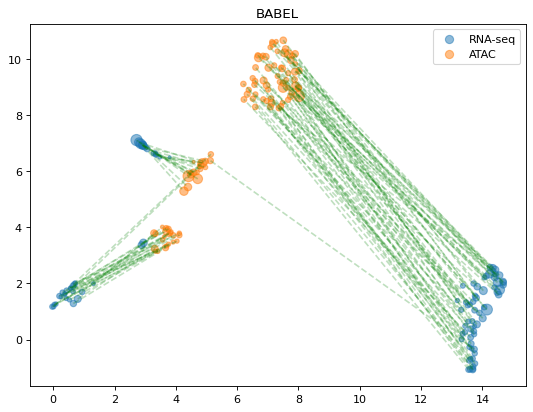

(0.1904372980141558, 0.62176895)

In [25]:
checkpoint = None
if path.exists(hyper['checkpoint_path']):
    checkpoint = torch.load(hyper["checkpoint_path"], map_location="cpu")

#load basic model
babel_model = NaiveSplicedAutoencoder(
    input_dim1=hyper["dim_rna"], 
    input_dim2=hyper["dim_atac"], 
    n_latent=hyper["n_latent"], 
    layer_sizes=hyper["layer_sizes"], 
    final_activation1=[Exp(), ClippedSoftplus()], 
    final_activation2=nn.Sigmoid(), 
    seed=182822,  
)
if checkpoint != None:
    babel_model.load_state_dict(checkpoint["model_state_dict"])
    
model_eval(babel_model, test_data_filtered, test_data_raw, title="BABEL")

In [23]:
#set up train functions
def main():
    
    #load training data and testing data
    train_loader, test_loader = get_data_loaders(
        train_data_filtered, 
        test_data_filtered,
        train_data_raw,
        test_data_raw,
    )
    
    #load checkpoint
    checkpoint = None
    if path.exists(hyper['checkpoint_path']):
        checkpoint = torch.load(hyper["checkpoint_path"])
    
    #load basic model
    babel_model = NaiveSplicedAutoencoder(
        input_dim1=hyper["dim_rna"], 
        input_dim2=hyper["dim_atac"], 
        n_latent=hyper["n_latent"], 
        layer_sizes=hyper["layer_sizes"], 
        final_activation1=[Exp(), ClippedSoftplus()], 
        final_activation2=nn.Sigmoid(), 
        seed=182822,  
    )
    if checkpoint != None:
        babel_model.load_state_dict(checkpoint["model_state_dict"])
        
    #set up losses
    criterion = QuadLoss()
    
    #set up optimizer
    babel_opt = optim.Adam(list(babel_model.parameters()), lr=hyper["lr"])
    babel_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        babel_opt, 
        patience=10, 
        threshold=0.01, 
        threshold_mode="abs",
        min_lr=1e-5,
    )
    #set up device 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    babel_model.to(device)
    
    best_knn_auc = 0
    if checkpoint != None:
        best_knn_auc = checkpoint["dev_acc"]
        
    #training step
    for epoch in range(hyper["nEpochs"]):
        train_losses = []
        for idx, (rna_inputs_filtered, atac_inputs_filtered, rna_inputs_raw, nn_indices) in enumerate(train_loader):
            babel_opt.zero_grad()

            rna_inputs_filtered = Variable(rna_inputs_filtered).to(device)
            atac_inputs_filtered = Variable(atac_inputs_filtered).to(device)
            rna_inputs_raw = Variable(rna_inputs_raw).to(device)
            nn_indices = Variable(nn_indices).to(device)
            
            inputs_list = [rna_inputs_filtered, atac_inputs_filtered]
            retval11, retval12, retval21, retval22 = babel_model(inputs_list)
            preds = (retval11, retval12, retval21, retval22)

            train_loss = criterion(preds, inputs_list)
            if hyper["add_hinge"]:
                hinge_loss = StructureHingeLoss(
                    margin=0.3, 
                    max_val=1e6, 
                    lamb_match=hyper["lamb_match"], 
                    lamb_nn=hyper["lamb_nn"],
                    device=device,
                )
                h_loss = hinge_loss(retval11[-1], retval22[-1], nn_indices)
                train_loss = train_loss + hyper["lamb_hinge"] * h_loss
                #train_loss = h_loss
                #print(f"hinge loss: {h_loss}")
                #print(f"train loss without hinge: {train_loss}")
            train_loss.backward()
            nn.utils.clip_grad_norm_(babel_model.parameters(), max_norm=hyper["clip_grad"])
            babel_opt.step()
            babel_scheduler.step(train_loss)

            train_losses.append(train_loss.item())
        avg_train_loss = np.mean(train_losses)
        if epoch % 5 == 0:
            print("Epoch: " + str(epoch) + ", train loss: " + str(avg_train_loss))
        
        #evaluating step
        with torch.no_grad():
            babel_model.eval()
            knn_acc = []
            #mse_acc = []
            for idx, samples in enumerate(test_loader):
                rna_inputs_filtered = samples[0].float().to(device)
                atac_inputs_filtered = samples[1].float().to(device)
                rna_inputs_raw = samples[2].float().to(device)
                
                inputs_list = [rna_inputs_filtered, atac_inputs_filtered]

                retval11, retval12, retval21, retval22 = babel_model(inputs_list)
                output_rna = retval11[-1]
                output_atac = retval22[-1]
                knn_acc.append(knn_criteria(rna_inputs_raw.cpu().detach(), output_rna.cpu().detach(), output_atac.cpu().detach()))
            avg_knn_auc = np.mean(knn_acc)
            
        #save checkpoint for model parameters that have best knn-auc so far
        if avg_knn_auc > best_knn_auc:
            torch.save({
                "epoch":epoch,
                "lamb_match":hyper["lamb_match"],
                "lamb_nn":hyper["lamb_nn"],
                "lamb_hinge":hyper["lamb_hinge"],
                "clip_grad":hyper['clip_grad'],
                "layer_sizes":hyper['layer_sizes'],
                "lr": hyper["lr"],
                "model_state_dict":babel_model.state_dict(),
                "optimizer_state_dict":babel_opt.state_dict(),
                "train_loss":avg_train_loss,
                "dev_acc":avg_knn_auc,
            }, hyper['checkpoint_path'])
            
        if epoch % 5 == 0:
            print("Epoch: " + str(epoch) + ", acc: " + str(avg_knn_auc))
    test_knn_score, test_mse_score = model_eval(babel_model, test_data_filtered, test_data_raw, device)
    print("Final knn_auc: " + str(test_knn_score))
    print("Final mse: " + str(test_mse_score))
    return babel_model

In [24]:
babel_model = main()

Epoch: 0, train loss: 27.164194253774788


RuntimeError: CUDA out of memory. Tried to allocate 120.00 MiB (GPU 0; 10.76 GiB total capacity; 3.62 GiB already allocated; 104.56 MiB free; 3.79 GiB reserved in total by PyTorch)

In [ ]:
print(babel_model)

In [ ]:
test_knn_score, test_mse_score = model_eval(babel_model, test_data_filtered, test_data_raw, device="cpu")
print("Final knn_auc: " + str(test_knn_score))
print("Final mse: " + str(test_mse_score))

In [ ]:
!nvidia-smi

In [ ]:
#log the metrics
path = "{}Max_iter_{}lamb_anc_{}metrics.txt".format(hyper["weightDirName"], str(hyper["nEpochs"]), str(hyper["lamb_anc"]))
'''torch.save({
    "num_iter": hyper["nEpochs"],
    "lamb_anc": hyper["lamb_anc"],
    'knn_auc': knn_score,
    'mse': mse_score,
}, path)'''

In [ ]:
with open(path, 'a') as f:
        print('nEpoch: ', hyper["nEpochs"], 'lamb_anc:%.8f'%float(hyper["lamb_anc"]) , ',knn_auc: %.8f' % float(knn_score), ', mse_score: %.8f' % float(mse_score), file=f)